In [1]:
import os
import pandas as pd
os.path.abspath(os.getcwd())
#Configuration pour afficher toutes les lignes a la sortie
pd.set_option('display.max_column', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_seq_items', None)
pd.set_option('display.max_colwidth', 500)
pd.set_option('expand_frame_repr', True)

In [2]:
os.chdir('/data/DT/09_Etudes_internes/01-Impayés/Extraction de données pour étude des impayés/itération du 23062023')
os.path.abspath(os.getcwd())

'/data/DT/09_Etudes_internes/01-Impayés/Extraction de données pour étude des impayés/itération du 23062023'

# Définition du problème
L’objectif de ce projet est de prédire quels assurés ne pourront pas payer leur cotisation d’assurance le mois suivant.

Un assuré est considéré comme "un impayé" s’il échoue au moins une fois lors des trois tentatives de prélèvement (3 vagues de prélèvement). Même si un rejet lors de la première vague peut être dû à une simple erreur de l’assuré, il représente tout de même un risque pour l’assureur et doit être pris en compte dans la prédiction.

La source de données contient des informations mensuelles sur chaque contrat et l'assuré souscripteur, entre 2019 et 2022.

La plupart des contrats sont payés régulièrement, et l’impayé est un événement ponctuel. Comme seul le statut de paiement change entre les enregistrements, cela risque de perturber le modèle à entraîner. Pour éviter cette confusion, on supprime les périodes où le contrat était en règle et ne conserve que celles où il était en impayé.<p> 
Finalement, on garde le dernier enregistrement pour chaque contrat afin d'eviter le risque de surapprentissage. <b>Pour ca, on doit créer la variable Y durant la préparation de données afin de ne pas perdre les cas impayés.</b>

### Importation et concaténation des tables contrats et adhérents

In [3]:
import pandas as pd

#Lecture des fichiers csv de la meme structure puis de les concatener
#Input: Liste des noms de table
#Output: Un Dataframe concatené
def read_then_concat(tables):
    l_df = []
    for tab in tables:
        l_df.append(pd.read_csv(tab, sep=";", decimal=",", encoding="latin9", low_memory=False))
    return pd.concat(l_df)
    
# Les fichiers contrats
                    
l_tab_contrats = ["EcaExtractEtudeDesImpayes_Contrats_2022.csv",
                 "EcaExtractEtudeDesImpayes_Contrats_2023.csv"]

df_contrat = read_then_concat(l_tab_contrats)
df_contrat = df_contrat.iloc[:,:-1]                    
                    
# Les fichiers adherents
                    
l_tab_adherents = ["EcaExtractEtudeDesImpayes_Adherents_2022.csv",
                  "EcaExtractEtudeDesImpayes_Adherents_2023.csv"]
df_adh = read_then_concat(l_tab_adherents)



In [4]:
#Concatenation des df contrat et adherent en faisant la jointure avec "PERIODE" et "CONTRAT"
df = pd.merge(df_contrat, df_adh,  how='left', left_on=['PERIODE','CONTRAT'], right_on = ['PERIODE','REF_CONTRAT'])

#Renommer des variables
df = df.rename(columns={'MOYENNE_AGE ADULTES': 'MOYENNE_AGE_ADULTES', 'MOYENNE AGE ENFANTS': 'MOYENNE_AGE_ENFANTS','SOMME_COTISATIONS ENCAISSEES':'SOMME_COTISATIONS_ENCAISSEES','SOMME_PRESTATIONS VERSEES': 'SOMME_PRESTATIONS_VERSEES','SOLDE COTISATION PERIODE':'SOLDE_COTISATION_PERIODE','DATE NAISSANCE':'DATE_NAISSANCE','CODE COMMUNE':'CODE_COMMUNE','MULTI-DETENTION':"MULTI_DETENTION"})

df.shape

(522621, 77)

## Suppression des colonnes 
Après l'exploration de la source des données, on supprime les colonnes vides, incohérentes,non pertinentes ou peu corrélées avec la variable à expliquer.

In [5]:
df.columns

Index(['PERIODE', 'CONTRAT', 'PRODUIT', 'CANAL_VENTE', 'DATE_SOUSC_CTT',
       'DATE_EFFET_CTT', 'GAR_PRINC', 'DATE_EFFET_GAR_PRINC', 'FRACTIONNEMENT',
       'STATUT_CONTRAT', 'PRIME_ANNUELLE_TTC_SOUSC', 'PRIME_ANNUELLE_TTC',
       'TAUX_REVALORISATION', 'TAUX_REVALORISATION_CUM', 'NB_BENEFICIAIRES',
       'NB_ADULTES', 'NB_ENFANTS', 'MOYENNE_AGE_ADULTES',
       'MOYENNE_AGE_ENFANTS', 'SOMME_COTISATIONS_ENCAISSEES',
       'SOMME_PRESTATIONS_VERSEES', 'TAUX_COUVERTURE',
       'SOLDE_COTISATION_PERIODE', 'GESTE_COMMERCIAL', 'VAGUE_PRELEVEMENT-_1',
       'DATE_PRELEVEMENT-_1', 'MOYEN_DE_PAIEMENT-_1', 'STATUT_PRELEVEMENT-_1',
       'DATE_REJET_PRELEVEMENT-_1', 'CANAL_RECLAMATION-_1',
       'VAGUE_PRELEVEMENT-_2', 'DATE_PRELEVEMENT-_2', 'MOYEN_DE_PAIEMENT-_2',
       'STATUT_PRELEVEMENT-_2', 'DATE_REJET_PRELEVEMENT-_2',
       'CANAL_RECLAMATION-_2', 'VAGUE_PRELEVEMENT-_3', 'DATE_PRELEVEMENT-_3',
       'MOYEN_DE_PAIEMENT-_3', 'STATUT_PRELEVEMENT-_3',
       'DATE_REJET_PRELEVEMEN

In [6]:
#Exclusion des colonnes non necessaires
df.drop(columns=['NOM', 'PRENOM', 'CONTRAT_1', 'CONTRAT_2', 'CONTRAT_3',
       'CONTRAT_4', 'CONTRAT_5', 'CONTRAT_6', 'CONTRAT_7', 'CONTRAT_8',
       'CONTRAT_9', 'CONTRAT_10','REF_CONTRAT', 'Unnamed: 31','TAUX_CHOMAGE','SALAIRE_MOYEN','EMAILS','APPELS','PROPRIETAIRE','TAUX_REVALORISATION_CUM', 'CSP'], axis=1, inplace=True)

# Préparation des données

### Changement des variables au formats conformes

In [7]:
from datetime import datetime
#Changement des dates en type datetime
def convert_to_datetime(col, date_format):
    return pd.to_datetime(col, format=date_format)

cols_ddmmyyyy = [
    'DATE_SOUSC_CTT', 
    'DATE_EFFET_CTT', 
    'DATE_EFFET_GAR_PRINC',
    'DATE_REJET_PRELEVEMENT-_1', 
    'DATE_REJET_PRELEVEMENT-_2', 
    'DATE_REJET_PRELEVEMENT-_3',
    'DATE_PRELEVEMENT-_1', 
    'DATE_PRELEVEMENT-_2', 
    'DATE_PRELEVEMENT-_3',
    'DATE_STATUT_CTT_MED', 
    'DATE_PAIEMENT_APRES_MED', 
    'DATE_NAISSANCE'
]

#Changement des dates en format ddmmyyyy
for col in cols_ddmmyyyy:
    df[col] = convert_to_datetime(df[col], '%d/%m/%Y')

#Changement des dates en format yyyymm
df['PERIODE_DATE'] = convert_to_datetime(df['PERIODE'], '%Y%m')

In [8]:
convert_dict = {'PERIODE': str,
                'CODE_COMMUNE': str,
                'DEPARTEMENT': str,
                'FRACTIONNEMENT':str,
                'SEXE':str,
                'SOLDE_COTISATION_PERIODE':float,
                "SOMME_COTISATIONS_ENCAISSEES":float,
                "MOYENNE_AGE_ADULTES":float,
                "MOYENNE_AGE_ENFANTS":float,
                "SOMME_PRESTATIONS_VERSEES":float
                }
 
df = df.astype(convert_dict)

In [9]:
#Changement des variables au bon format
df.loc[df["DEPARTEMENT"]=="97","DEPARTEMENT"] = df["CODE_COMMUNE"].str[:3]
df.loc[df["DEPARTEMENT"].str.len()==1, "DEPARTEMENT"] = "0" + df["DEPARTEMENT"]

In [10]:
#Supprimer les obs du departement 976 et 978
df = df[-df["DEPARTEMENT"].isin(["976","978"])]


### Suppression des contrats souscrits avant 2019 et non actifs.
Les anciens contrats ne peuvent pas être correctement fiabilisé. Nous intéressons aux contrats actifs


In [11]:
df = df[(df['DATE_SOUSC_CTT']>='2019-01-01')]
df = df[~df.STATUT_CONTRAT.isin(["SANS_EFFET", "MIGRE", "DEVIS_ATTENTE_PIECES", "RESILIE", "RESILIE_FUTUR"])]

In [12]:
df.shape

(452133, 57)

## Création de la variable à expliquer

In [13]:
#Creation de la variable à expliquer
import numpy as np
df['IMPAYE'] = np.where((df["STATUT_PRELEVEMENT-_1"]=="Rejeté") | (df["STATUT_PRELEVEMENT-_2"]=="Rejeté") | (df["STATUT_PRELEVEMENT-_3"]=="Rejeté"), 1, 0)

In [14]:
df.IMPAYE.value_counts()

0    422174
1     29959
Name: IMPAYE, dtype: int64

In [15]:
sum_impaye = df.groupby("CONTRAT")['IMPAYE'].sum()

#Liste des contrats ayant au moins un impayé
l_impaye = list(sum_impaye.loc[sum_impaye>0].index.values)

#Liste des contrats n'ayant jamais eu d'un impayé
l_paye = list(sum_impaye.loc[sum_impaye==0].index.values)

#Puisque c'est une table historique, pour chaque contrat ayant au moins un impayé, on supprime toutes leurs historiques avec leurs donnees payées.
df = df[~((df.CONTRAT.isin(l_impaye)) & (df.IMPAYE==0))]

In [16]:
#On garde que la derniere version de chaque contrat
df = df.drop_duplicates(subset=['CONTRAT'],keep="last")
df = df.sort_values('CONTRAT')
df.IMPAYE.value_counts()


0    28484
1    13350
Name: IMPAYE, dtype: int64

## Feature Engineering

In [17]:
#importation des donnees sources
moins_25 = pd.read_csv("../../data/demandeurs_emploi_moins_25.csv", sep=";", skiprows=3, skipfooter=2, encoding="utf-8", engine='python')
plus_50 = pd.read_csv("../../data/demandeurs_emploi_plus_50.csv", sep=";", skiprows=3, skipfooter=2, encoding="utf-8", engine='python')
entre_25_49 = pd.read_csv("../../data/demandeurs_emploi_25_49.csv", sep=";", skiprows=3, skipfooter=2, encoding="utf-8", engine='python')

In [18]:
#Fonction pour pre traiter les donnees sources
import locale
locale.setlocale(locale.LC_TIME,'')
from datetime import datetime

def clean_demandeurs_emploi(data):
    for col in data.columns[1:-1]:
        data = data.rename({col: col[-3:]}, axis=1)
        data = data.rename({"Mois":"PERIODE"}, axis=1)
    data['PERIODE']= pd.to_datetime(data['PERIODE'],format="%d/%m/%Y")
    data['PERIODE']=data['PERIODE'].apply(lambda x:datetime.strftime(x,"%Y%m"))
    data.columns = data.columns.str.replace(' ', '')
    data = data.replace(regex=" ", value="")
    cols = data.iloc[:,1:data.shape[1]-1].select_dtypes(include='object').columns
    data[cols] = data[cols].astype(int)
    data = data.drop(["Total"], axis=1)
    return data

In [19]:
moins_25 = clean_demandeurs_emploi(moins_25)
plus_50 = clean_demandeurs_emploi(plus_50)
entre_25_49 = clean_demandeurs_emploi(entre_25_49)

In [20]:
#On cree une matrice afin de faire la jointure avec df principale. 
#Pour ca, on cree une matrice avec periode, departement et tranche d'age qui seront utilisees en tant que des cles
import numpy as np

def create_df_chomeurs(df,name):
    df_t = df.iloc[:,1:].transpose()
    a = df_t.iloc[0,:]
    b = df_t.index[0]
    c = df.iloc[:,0]
    d = {'PERIODE':c, 'DEPARTEMENT':b,'NB_CHOMEURS':a}
    new=pd.DataFrame(d)
    for i in range(1,np.shape(df_t)[0]):
        a = df_t.iloc[i,:]
        b = df_t.index[i]
        c = df.iloc[:,0]
        d = {'PERIODE':c, 'DEPARTEMENT':b,'NB_CHOMEURS':a}
        new2=pd.DataFrame(d)
        new = pd.concat([new,new2])
    new["TRANCHE_AGE_CHOM"]=name
    return new

c_moins_25 = create_df_chomeurs(moins_25, "Moins 25")
c_entre_25_49 = create_df_chomeurs(entre_25_49, "Entre 25 et 49")
c_plus_50 = create_df_chomeurs(plus_50, "Plus 50")

df_chomeurs = pd.concat([c_moins_25, c_entre_25_49, c_plus_50])
df_chomeurs = df_chomeurs.reset_index(drop=True)


In [21]:
from datetime import date
def get_age(born,periode):
    return periode.year - born.year - ((periode.month, periode.day) < (born.month, born.day))
#Creation de la variable age
df["AGE"] = df.apply(lambda x: get_age(x['DATE_NAISSANCE'],datetime.strptime(str(x["PERIODE"]),"%Y%m")),axis=1)
df["AGE_SOUSC"] = df.apply(lambda x: get_age(x['DATE_NAISSANCE'],x["DATE_SOUSC_CTT"]),axis=1)

In [22]:
#Creation de variable tranche_age dans df principale
conditions = [
    df['AGE']<25,
    df['AGE']>50
]
choices = ["Moins 25","Plus 50"]
df['TRANCHE_AGE_CHOM'] = np.select(conditions, choices, default="Entre 25 et 49")

In [23]:
#Creation de variable annee pour jointure
df["ANNEE"] = df["PERIODE"].str[:4]
df_chomeurs["ANNEE"] = df_chomeurs["PERIODE"].str[:4]
df_chomeurs.drop("PERIODE",axis=1,inplace=True)

df.reset_index(drop=True)
df = pd.merge(df, df_chomeurs,  how='left', left_on=['ANNEE','DEPARTEMENT', 'TRANCHE_AGE_CHOM'], right_on = ['ANNEE','DEPARTEMENT','TRANCHE_AGE_CHOM'])
#df.drop('Annee', axis=1, inplace=True)

In [24]:
df.head()

,PERIODE,CONTRAT,PRODUIT,CANAL_VENTE,DATE_SOUSC_CTT,DATE_EFFET_CTT,GAR_PRINC,DATE_EFFET_GAR_PRINC,FRACTIONNEMENT,STATUT_CONTRAT,PRIME_ANNUELLE_TTC_SOUSC,PRIME_ANNUELLE_TTC,TAUX_REVALORISATION,NB_BENEFICIAIRES,NB_ADULTES,NB_ENFANTS,MOYENNE_AGE_ADULTES,MOYENNE_AGE_ENFANTS,SOMME_COTISATIONS_ENCAISSEES,SOMME_PRESTATIONS_VERSEES,TAUX_COUVERTURE,SOLDE_COTISATION_PERIODE,GESTE_COMMERCIAL,VAGUE_PRELEVEMENT-_1,DATE_PRELEVEMENT-_1,MOYEN_DE_PAIEMENT-_1,STATUT_PRELEVEMENT-_1,DATE_REJET_PRELEVEMENT-_1,CANAL_RECLAMATION-_1,VAGUE_PRELEVEMENT-_2,DATE_PRELEVEMENT-_2,MOYEN_DE_PAIEMENT-_2,STATUT_PRELEVEMENT-_2,DATE_REJET_PRELEVEMENT-_2,CANAL_RECLAMATION-_2,VAGUE_PRELEVEMENT-_3,DATE_PRELEVEMENT-_3,MOYEN_DE_PAIEMENT-_3,STATUT_PRELEVEMENT-_3,DATE_REJET_PRELEVEMENT-_3,CANAL_RECLAMATION-_3,DATE_STATUT_CTT_MED,DATE_PAIEMENT_APRES_MED,NB_PRIMES_REGLEES,NB_PRIMES_RETARD,ID,DATE_NAISSANCE,SEXE,STATUT_MARITAL,REGIME_OBLIGATOIRE,VILLE,CODE_COMMUNE,DEPARTEMENT,MULTI_DETENTION,FLAG_IMPAYES_AUTCTT,BANQUE,PERIODE_DATE,IMPAYE,AGE,AGE_SOUSC,TRANCHE_AGE_CHOM,ANNEE,NB_CHOMEURS
0,202305,CACTIVA1900014,Sant'Actif,RCS,2019-04-02,2019-04-01,Activ'150,2019-04-01,12,CONTRAT,1081.32,1403.91,1.0,3,2,1,32.0,7.0,116.99,248.42,89.69,0.0,0,1.0,2023-05-10,Prélèvement,Rejeté,2023-05-12,NaN,NaN,NaT,NaN,NaN,NaT,NaN,NaN,NaT,NaN,NaN,NaT,NaN,2020-04-29,2020-05-05,28,0,1935729271,1990-07-20,0,MARIE,REGIME_GENERAL,Fenain,59179,59,2,1,CRCAM NORD DE FRANCE,2023-05-01,1,32,28,Entre 25 et 49,2023,169840.0
1,202305,CACTIVA1900026,Sant'Actif,RCS,2019-04-02,2019-04-01,Activ'150,2019-04-01,12,CONTRAT,658.96,878.25,1.0,1,1,0,54.0,0.0,73.19,571.37,100.00,0.0,0,1.0,2023-05-10,NaN,Prélevé,NaT,NaN,NaN,NaT,NaN,NaN,NaT,NaN,NaN,NaT,NaN,NaN,NaT,NaN,2019-12-30,2020-01-09,28,0,1937054477,1969-01-14,0,MARIE,REGIME_GENERAL,Margny Les Compiegne,60280,60,4,1,LA BANQUE POSTALE,2023-05-01,0,54,50,Plus 50,2023,17800.0
2,202305,CACTIVA1900069,Sant'Actif,RCS,2019-04-03,2019-05-01,Activ'100,2019-05-01,12,CONTRAT,553.16,812.46,1.0,1,1,0,53.0,0.0,67.71,43.08,100.00,0.0,0,1.0,2023-05-10,NaN,Prélevé,NaT,NaN,NaN,NaT,NaN,NaN,NaT,NaN,NaN,NaT,NaN,NaN,NaT,NaN,NaT,NaT,29,0,1938908970,1969-12-31,0,MARIE,REGIME_GENERAL,Aulnay Sous Bois,93600,93,1,0,CAISSE D EPARGNE ILE DE FRANCE,2023-05-01,0,53,49,Plus 50,2023,47800.0
3,202305,CACTIVA1900090,Sant'Actif,COURTAGE,2019-04-04,2019-04-01,Activ'100,2019-04-01,12,CONTRAT_ATTENTE_PIECES,451.10,656.73,1.0,1,1,0,52.0,0.0,54.73,0.00,0.00,0.0,0,1.0,2023-05-10,NaN,Prélevé,NaT,NaN,NaN,NaT,NaN,NaN,NaT,NaN,NaN,NaT,NaN,NaN,NaT,NaN,NaT,NaT,28,0,1949555790,1971-01-24,0,CELIBATAIRE,REGIME_GENERAL,Blois,41000,41,1,0,BNP PARIBAS,2023-05-01,0,52,48,Plus 50,2023,7580.0
4,202305,CACTIVA1900091,Sant'Actif,RCS,2019-04-04,2019-05-01,Activ'150,2019-05-01,12,CONTRAT,738.53,1032.03,1.0,1,1,0,57.0,0.0,86.00,224.83,44.36,0.0,0,1.0,2023-05-10,NaN,Prélevé,NaT,NaN,NaN,NaT,NaN,NaN,NaT,NaN,NaN,NaT,NaN,NaN,NaT,NaN,NaT,NaT,18,0,1942248353,1966-01-13,1,CELIBATAIRE,REGIME_GENERAL,Cormeilles En Parisis,95240,95,1,0,LA BANQUE POSTALE,2023-05-01,0,57,53,Plus 50,2023,28550.0


In [25]:
#Creation de variable tranche_age dans df principale
conditions = [
    df['AGE']<=25,
    (df['AGE']>25) & (df['AGE']<=35),
    (df['AGE']>35) & (df['AGE']<=45),
    (df['AGE']>45) & (df['AGE']<=55),
    (df['AGE']>55)
]
choices = ["Moins 25", "26-35","36-45","46-55","Plus 55"]
df['TRANCHE_AGE'] = np.select(conditions, choices, default="0")

In [26]:
def diff_date_na(a,b):
    if (pd.isnull(a) | (pd.isnull(b))): return -999999
    else: return (a-b).days

df["DELAI_EFFET"] = df.apply(lambda x: diff_date_na(x["DATE_EFFET_CTT"],x["DATE_SOUSC_CTT"]),axis=1)
df["DELAI_EFFET_GAR"] = df.apply(lambda x: diff_date_na(x["DATE_EFFET_GAR_PRINC"],x["DATE_SOUSC_CTT"]),axis=1)
df["DELAI_GAR_EFF_REJET_1"] = df.apply(lambda x: diff_date_na(x["DATE_REJET_PRELEVEMENT-_1"],x["DATE_EFFET_GAR_PRINC"]),axis=1)
df["DELAI_GAR_EFF_REJET_2"] = df.apply(lambda x: diff_date_na(x["DATE_REJET_PRELEVEMENT-_2"],x["DATE_EFFET_GAR_PRINC"]),axis=1)
df["DELAI_GAR_EFF_REJET_3"] = df.apply(lambda x: diff_date_na(x["DATE_REJET_PRELEVEMENT-_3"],x["DATE_EFFET_GAR_PRINC"]),axis=1)
df["DELAI_PAIEMENT_APRES_MED"] = df.apply(lambda x: diff_date_na(x["DATE_PAIEMENT_APRES_MED"],x["DATE_STATUT_CTT_MED"]),axis=1)
#df["DELAI_PAIEMENT_APRES_MED"] = diff_date_na(df["DATE_PAIEMENT_APRES_MED"], df["DATE_STATUT_CTT_MED"])
df["DELAI_PAIEMENT_2_REJET_1"] = df.apply(lambda x: diff_date_na(x["DATE_PRELEVEMENT-_2"],x["DATE_REJET_PRELEVEMENT-_1"]),axis=1)
df["DELAI_PAIEMENT_3_REJET_2"] = df.apply(lambda x: diff_date_na(x["DATE_PRELEVEMENT-_3"],x["DATE_REJET_PRELEVEMENT-_2"]),axis=1)
df["DELAI_ENTRE_MED_REJET_3"] = df.apply(lambda x: diff_date_na(x["DATE_STATUT_CTT_MED"],x["DATE_REJET_PRELEVEMENT-_3"]),axis=1)

In [27]:
df.STATUT_MARITAL.loc[(df.NB_BENEFICIAIRES==1)] = "SOLO"
df.STATUT_MARITAL.loc[(df.NB_BENEFICIAIRES==2)] = "DUO"
df.STATUT_MARITAL.loc[(df.NB_BENEFICIAIRES>=3)] = "FAMILLE"

/opt/anaconda3/envs/etl_clee/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [28]:
df.reset_index(inplace=True,drop=True)

In [29]:
#df = df_old.copy()

In [30]:
cols = ["IMPAYE","PERIODE","CONTRAT","PRODUIT","CANAL_VENTE","GAR_PRINC","FRACTIONNEMENT","STATUT_CONTRAT","PRIME_ANNUELLE_TTC_SOUSC","PRIME_ANNUELLE_TTC","TAUX_COUVERTURE","TAUX_REVALORISATION","NB_BENEFICIAIRES","NB_ADULTES","NB_ENFANTS","MOYENNE_AGE_ADULTES", "MOYENNE_AGE_ENFANTS","SOLDE_COTISATION_PERIODE","NB_PRIMES_REGLEES","NB_PRIMES_RETARD","DATE_NAISSANCE","SEXE","STATUT_MARITAL","REGIME_OBLIGATOIRE","VILLE","CODE_COMMUNE","DEPARTEMENT","MULTI_DETENTION","FLAG_IMPAYES_AUTCTT","BANQUE","AGE","AGE_SOUSC","TRANCHE_AGE_CHOM","NB_CHOMEURS","TRANCHE_AGE","ANNEE","DELAI_EFFET","DELAI_EFFET_GAR","DELAI_GAR_EFF_REJET_1","DELAI_GAR_EFF_REJET_2","DELAI_GAR_EFF_REJET_3","DELAI_PAIEMENT_APRES_MED","DELAI_PAIEMENT_2_REJET_1","DELAI_PAIEMENT_3_REJET_2","DELAI_ENTRE_MED_REJET_3"]

df = df[cols]

## Detection des variables avec des donnees manquantes

In [31]:
#retourne les variables ayant entre 1% et 50% des NA
#retourne les variables ayant moins 1% de vides
#retourne les variables ayant plus de 50% de vides
def detecter_var_na(df):
    prop_non_vide = 100-df.isnull().mean().round(6).mul(100).sort_values(ascending=False)
    prop_vide = 100 - prop_non_vide
    var_sup_50 = prop_vide[(prop_vide>50)].index.tolist()
    var_inf_1 = prop_vide[(prop_vide<1) & (prop_vide>0)].index.tolist()
    var_impute = prop_vide[(prop_vide>=1) &(prop_vide<=50)].index.tolist()
    return var_impute, var_sup_50, var_inf_1,prop_vide
    

In [32]:
l_impute, l_sup_50, l_inf_1,prop_vide = detecter_var_na(df)
#prop_vide

In [33]:
print(l_impute)
print(l_sup_50)
print(l_inf_1)

[]
[]
['BANQUE', 'NB_CHOMEURS', 'REGIME_OBLIGATOIRE', 'VILLE']


In [34]:
df = df.drop(columns=["PERIODE","CONTRAT","DATE_NAISSANCE","VILLE","BANQUE","ANNEE","CODE_COMMUNE"])
df.drop(df[df.REGIME_OBLIGATOIRE.isna()].index, inplace=True)

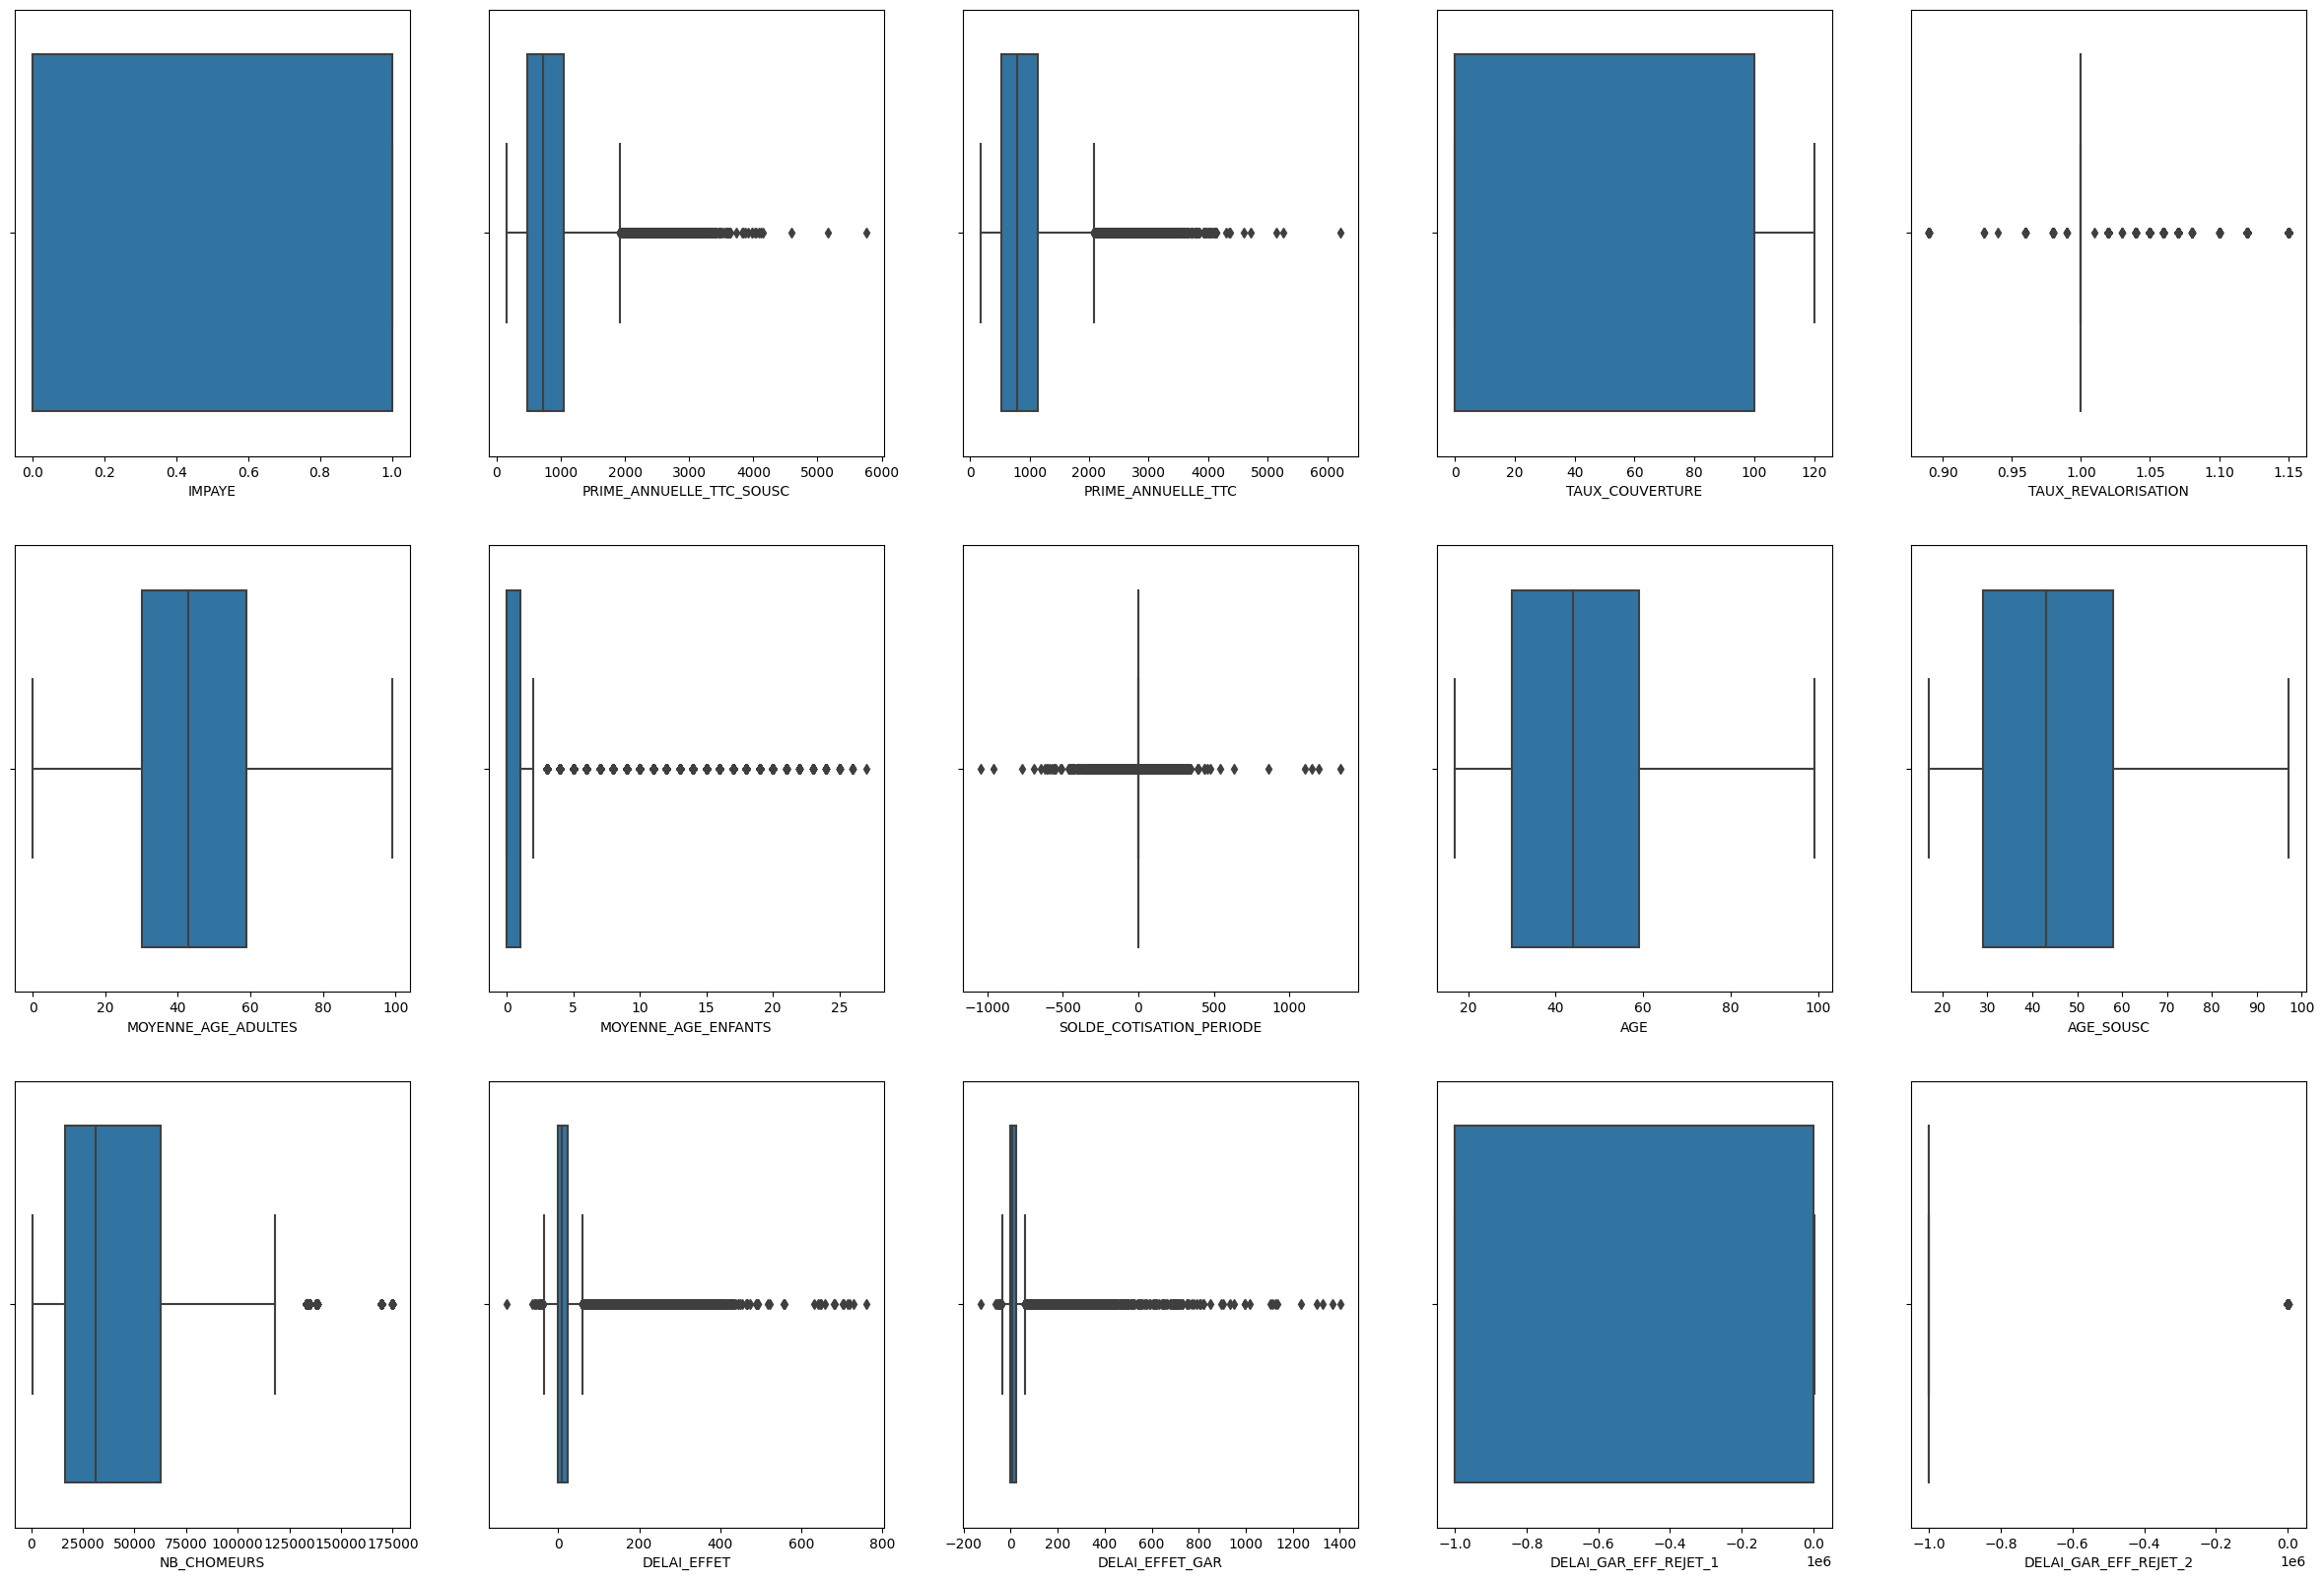

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt
X_num = df.select_dtypes(include=['number']).columns.tolist()
X_num_dist = ["NB_PRIMES_REGLEES","NB_ADULTES","NB_BENEFICIAIRES","NB_ENFANTS","NB_PRIMES_RETARD","MULTI_DETENTION","FLAG_IMPAYES_AUTCTT"]
X_num_cont = [x for x in X_num if x not in X_num_dist]

nrows = 3
ncols = 5

# subplot 크기 설정
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(30, 20))

# subplot 순서대로 그래프 그리기
for i in range(nrows):
    for j in range(ncols):
        index = i * ncols + j  # 그래프 인덱스
        if index >= len(X_num_cont):  # 인덱스가 변수 개수를 초과하면 그리지 않음
            break
        sns.boxplot(x=X_num_cont[index], data=df, ax=axs[i, j])
            
# 그래프 출력
plt.show()

In [36]:
#On decide de supprimer certaines variables qui ont l'air vides

X_to_drop = ["MOYENNE_AGE_ENFANTS",'SOLDE_COTISATION_PERIODE','DELAI_GAR_EFF_REJET_1','DELAI_GAR_EFF_REJET_2','DELAI_GAR_EFF_REJET_3','DELAI_PAIEMENT_APRES_MED','DELAI_PAIEMENT_2_REJET_1','DELAI_PAIEMENT_3_REJET_2','DELAI_ENTRE_MED_REJET_3']
df.drop(columns=X_to_drop,inplace=True, axis=1)

In [37]:
#On supprime les variables ayant un VIF élevé
X_to_drop = ['NB_ADULTES','NB_ENFANTS','AGE_SOUSC','PRIME_ANNUELLE_TTC_SOUSC','MOYENNE_AGE_ADULTES','FLAG_IMPAYES_AUTCTT']
df.drop(columns=X_to_drop,inplace=True, axis=1)

In [38]:
df.drop(columns=["AGE"],inplace=True, axis=1)

In [39]:
df.dtypes

IMPAYE                   int64
PRODUIT                 object
CANAL_VENTE             object
GAR_PRINC               object
FRACTIONNEMENT          object
STATUT_CONTRAT          object
PRIME_ANNUELLE_TTC     float64
TAUX_COUVERTURE        float64
TAUX_REVALORISATION    float64
NB_BENEFICIAIRES         int64
NB_PRIMES_REGLEES        int64
NB_PRIMES_RETARD         int64
SEXE                    object
STATUT_MARITAL          object
REGIME_OBLIGATOIRE      object
DEPARTEMENT             object
MULTI_DETENTION          int64
TRANCHE_AGE_CHOM        object
NB_CHOMEURS            float64
TRANCHE_AGE             object
DELAI_EFFET              int64
DELAI_EFFET_GAR          int64
dtype: object

In [40]:
print(df.shape)
df["IMPAYE"].value_counts()

(41832, 22)


0    28483
1    13349
Name: IMPAYE, dtype: int64

In [41]:
os.chdir('/home/clee/Impaye')
os.path.abspath(os.getcwd())
df.to_csv("new_data.csv", sep=";", decimal = ",", index=False)

In [42]:
df['prime_ratio'] = df['NB_PRIMES_REGLEES'] / df['TAUX_REVALORISATION']
df['prime_cat'] = pd.cut(df['NB_PRIMES_REGLEES'], bins=[0, 10, 20, 30, 50, 100, 500], labels=['0-10', '10-20', '20-30', '30-50', '50-100', '100+'])
df.drop(['NB_PRIMES_REGLEES', 'TAUX_REVALORISATION'], axis=1, inplace=True)
df.to_csv("new_data_v2.csv", sep=";", decimal = ",", index=False)

In [43]:
df.head()

,IMPAYE,PRODUIT,CANAL_VENTE,GAR_PRINC,FRACTIONNEMENT,STATUT_CONTRAT,PRIME_ANNUELLE_TTC,TAUX_COUVERTURE,NB_BENEFICIAIRES,NB_PRIMES_RETARD,SEXE,STATUT_MARITAL,REGIME_OBLIGATOIRE,DEPARTEMENT,MULTI_DETENTION,TRANCHE_AGE_CHOM,NB_CHOMEURS,TRANCHE_AGE,DELAI_EFFET,DELAI_EFFET_GAR,prime_ratio,prime_cat
0,1,Sant'Actif,RCS,Activ'150,12,CONTRAT,1403.91,89.69,3,0,0,FAMILLE,REGIME_GENERAL,59,2,Entre 25 et 49,169840.0,26-35,-1,-1,28.0,20-30
1,0,Sant'Actif,RCS,Activ'150,12,CONTRAT,878.25,100.00,1,0,0,SOLO,REGIME_GENERAL,60,4,Plus 50,17800.0,46-55,-1,-1,28.0,20-30
2,0,Sant'Actif,RCS,Activ'100,12,CONTRAT,812.46,100.00,1,0,0,SOLO,REGIME_GENERAL,93,1,Plus 50,47800.0,46-55,28,28,29.0,20-30
3,0,Sant'Actif,COURTAGE,Activ'100,12,CONTRAT_ATTENTE_PIECES,656.73,0.00,1,0,0,SOLO,REGIME_GENERAL,41,1,Plus 50,7580.0,46-55,-3,-3,28.0,20-30
4,0,Sant'Actif,RCS,Activ'150,12,CONTRAT,1032.03,44.36,1,0,1,SOLO,REGIME_GENERAL,95,1,Plus 50,28550.0,Plus 55,27,27,18.0,10-20
